In [1]:
import torch
from torchvision.transforms.functional import to_tensor
import segmentation_models_pytorch as smp
from typing import Final
import os
from torchvision import transforms as T
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2
import rasterio
from torchvision.transforms import ToTensor, ToPILImage
from segmentation_models_pytorch.utils.metrics import IoU
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
import math, decimal
#! pip install dataframe_image

import dataframe_image as dfi

/Users/daria/Documents/botay/diplom 5 course/cv-corruption-research/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

False

## Import model

In [55]:

architectures: Final[dict] = {'Unet': smp.Unet,
                              'Unet++': smp.UnetPlusPlus,
                              'MAnet': smp.MAnet,
                              'DeepLabV3+': smp.DeepLabV3Plus}

encoders: Final[dict] = {'mit-b2': 'mit_b2',
                         'mit-b3': 'mit_b3',
                         'efficientnet-b1': 'efficientnet-b1',
                         'efficientnet-b2': 'efficientnet-b2',
                         'efficientnet-b3': 'efficientnet-b3',
                         'efficientnet-b4': 'efficientnet-b4',
                         'efficientnet-b5': 'efficientnet-b5',
                         'timm-res2net50-26w-4s': 'timm-res2net50_26w_4s'}

models_root = 'D:\diploma\cv-corruption-research\models'
model_names = ['DeepLabV3+_efficientnet-b4' , 'MAnet_efficientnet-b4', 'Unet_mit-b2', 'Unet++_efficientnet-b5']

model_name = model_names[0]

segm_arch = model_name.split('_')[0]
encoder = model_name.split('_')[1]

model = architectures[segm_arch](in_channels = 3, classes=4, 
                                 encoder_name = encoders[encoder],
                                 encoder_weights=None,
                                 activation = None).to('cuda')

model.load_state_dict(torch.load(os.path.join(models_root, f'{model_name}.pth')))
model.eval();

## Inference model

In [5]:
normparams= {'mean': [105.  , 109.,  100.], 'std': [53.660343, 51.114082, 51.887432]}

def get_img_transform(normparams):
    return T.Compose([T.Lambda(lambda x: torch.as_tensor(x, dtype=torch.float)),
                      T.Normalize(**normparams)])


def get_mask_inverse_transform():
    def transform(x):
        x = x.detach().cpu().numpy()
        return x
    return transform


def get_predictor(model,
                  transform,
                  inv_transform,
                  device: str = 'cpu'):
    def predictor(sample):
        model.eval()
        model.to(device)
        with torch.no_grad():
            return inv_transform(model(torch.unsqueeze(transform(sample), 0).to(device))[0])
    return predictor

sample_size=(1024,1024)

def add_border(img):
        img = to_tensor(img)

        old_size = (img.shape[1], img.shape[2])

        new_size = ((int(old_size[0] / sample_size[0]) + 1)*sample_size[0], 
                    (int(old_size[1] / sample_size[1]) + 1)*sample_size[1])
            
        new_img = torch.zeros((img.shape[0], new_size[0], new_size[1]))
        
        add_x = [int((new_size[0]-old_size[0])/2), int((new_size[0]-old_size[0])/2)]
        add_y = [int((new_size[1]-old_size[1])/2), int((new_size[1]-old_size[1])/2)]

        if new_size[0]-np.sum(add_x) != img.shape[1]:
            add_x[1] = add_x[1] + 1

        if new_size[1]-np.sum(add_y) != img.shape[2]:
            add_y[1] = add_y[1] + 1

        new_img[:, add_x[0]:new_size[0]-add_x[1], 
                   add_y[0]:new_size[1]-add_y[1]] = img

        return new_img.detach().cpu().numpy()


predictor = get_predictor(model,
                          transform=get_img_transform(normparams),
                          inv_transform=get_mask_inverse_transform(),
                          device='cuda')



# Cropp images for GPU optimization

In [ ]:
pic_num = 13
IoU_res, p, r, f1 = [],[],[],[]

for i in range(pic_num):
    image = rasterio.open("true_images/"+ str(i+1) +".tif")
    true_mask = rasterio.open("true_rastr_masks/"+ str(i+1) +".tif")

    # cropp images for GPU optimization
    x = image.read()
    x = torch.tensor(x)
    kernel_size, stride = 1024, 1024
    patches = x.unfold(1, kernel_size, stride).unfold(2, kernel_size, stride)
    patches = patches.contiguous().view(patches.size(0), -1, kernel_size, kernel_size)
    patches = patches.swapaxes(0,1).swapaxes(1,3)
    
     # cropp mask for GPU optimization
    true_mask = true_mask.read()
    true_mask = torch.tensor(true_mask)
    kernel_size, stride = 1024, 1024
    mask_patches = true_mask.unfold(1, kernel_size, stride).unfold(2, kernel_size, stride)
    mask_patches = mask_patches.contiguous().view(mask_patches.size(0), -1, kernel_size, kernel_size)
    mask_patches = mask_patches.swapaxes(0,1).swapaxes(1,3)
    val_idx = []

    # drop pics with no buildings
    for i in range(len(mask_patches)):
        if mask_patches[i].sum() != 0:
            val_idx.append(i)
    
    for j in val_idx:
        
        image = patches[j].swapaxes(0,2).swapaxes(1,2)
        true_mask = mask_patches[j]

        mask = predictor(image) #returns mask with raw logits, shape = (4, H, W)

        mask = torch.argmax(torch.from_numpy(mask), dim=0)
        mask = mask == 3

        true_mask = true_mask[:,:,0]

        
        fig, axes= plt.subplots(1,3)
        axes[0].imshow(image.swapaxes(0,1).swapaxes(1,2))
        axes[1].imshow(true_mask)
        axes[2].imshow(mask)

        axes[0].set_title('Image')
        axes[1].set_title('True mask')
        axes[2].set_title('Predict mask')
        plt.show()
        
        
        iou = IoU()
        IoU_ = iou(mask,true_mask).item()
        
        true_mask, mask = true_mask.numpy().flatten(), mask.flatten()
        precision = precision_score(true_mask, mask)
        recall = recall_score(true_mask, mask)
        f1_ = f1_score(true_mask, mask)
        
        p.append(precision)
        r.append(recall)
        f1.append(f1_)
        IoU_res.append(IoU_)

        print(f1_,precision,recall,IoU_)
    
print(np.mean(f1), np.mean(p), np.mean(r), np.mean(IoU_res))

# Count metrics for distorted images

In [ ]:
pic_num = 13
names = ['adjust_contrast', 'adjust_gamma', 'adjust_hue', 'adjust_saturation', 'Grayscale', 'webp']

for name in names:
    IoU_res, p, r, f1 = [],[],[],[]
    for i in range(pic_num):
        image = rasterio.open("distorted_images/"+ name + '/' + str(i+1) +".tif")
        true_mask = rasterio.open("true_rastr_masks/"+ str(i+1) +".tif")

        # cropp images for GPU optimization
        x = image.read()
        x = torch.tensor(x)
        kernel_size, stride = 1024, 1024
        patches = x.unfold(1, kernel_size, stride).unfold(2, kernel_size, stride)
        patches = patches.contiguous().view(patches.size(0), -1, kernel_size, kernel_size)
        patches = patches.swapaxes(0,1).swapaxes(1,3)
        
        # cropp mask for GPU optimization
        true_mask = true_mask.read()
        true_mask = torch.tensor(true_mask)
        kernel_size, stride = 1024, 1024
        mask_patches = true_mask.unfold(1, kernel_size, stride).unfold(2, kernel_size, stride)
        mask_patches = mask_patches.contiguous().view(mask_patches.size(0), -1, kernel_size, kernel_size)
        mask_patches = mask_patches.swapaxes(0,1).swapaxes(1,3)
        val_idx = []

        # drop pics with no buildings
        for i in range(len(mask_patches)):
            if mask_patches[i].sum() != 0:
                val_idx.append(i)
        
        for j in val_idx:
            
            image = patches[j].swapaxes(0,2).swapaxes(1,2)
            true_mask = mask_patches[j]

            mask = predictor(image) #returns mask with raw logits, shape = (4, H, W)

            mask = torch.argmax(torch.from_numpy(mask), dim=0)
            mask = mask == 3

            true_mask = true_mask[:,:,0]

            '''
            fig, axes= plt.subplots(1,3)
            axes[0].imshow(image.swapaxes(0,1).swapaxes(1,2))
            axes[1].imshow(true_mask)
            axes[2].imshow(mask)

            axes[0].set_title('Image')
            axes[1].set_title('True mask')
            axes[2].set_title('Predict mask')
            plt.show()
            '''
            
            iou = IoU()
            IoU_ = iou(mask,true_mask).item()
            
            true_mask, mask = true_mask.numpy().flatten(), mask.flatten()
            precision = precision_score(true_mask, mask)
            recall = recall_score(true_mask, mask)
            f1_ = f1_score(true_mask, mask)
            
            p.append(precision)
            r.append(recall)
            f1.append(f1_)
            IoU_res.append(IoU_)

            #print(f1_,precision,recall,IoU_)
    
    print(name, np.mean(f1), np.mean(p), np.mean(r), np.mean(IoU_res))

# 0. Count and save metrics

*webp is not prametric

In [3]:
pic_num = 13
transf_names = ['adjust_contrast', 'adjust_gamma', 'adjust_hue', 'adjust_saturation', 'Grayscale','webp']
pars = [{'contrast_factor':[0.2, 0.5, 0.8, 1.2, 1.5, 1.8, 2]}, {'gamma':[0.2, 0.5, 0.8, 1.2, 1.5, 1.8, 1.9, 2.3]}, {'hue_factor':[-0.5, -0.4, -0.2, -0.1, 0, 0.1, 0.2, 0.4, 0.5]}, {'saturation_factor':[0, 0.3, 0.5, 0.8, 1.3, 1.5, 1.8, 2]}]


In [168]:
for model_name in model_names:
    segm_arch = model_name.split('_')[0]
    encoder = model_name.split('_')[1]
    model = architectures[segm_arch](in_channels = 3, classes=4, 
                                    encoder_name = encoders[encoder],
                                    encoder_weights=None,
                                    activation = None).to('cuda')

    model.load_state_dict(torch.load(os.path.join(models_root, f'{model_name}.pth')))
    model.eval()
    predictor = get_predictor(model,
                          transform=get_img_transform(normparams),
                          inv_transform=get_mask_inverse_transform(),
                          device='cuda')
    
    for transf_name, par in zip(transf_names, pars):
        par_name, par_val_list = next(iter(par.items()))
        for par_i in par_val_list:
            IoU_res, p, r, f1 = [],[],[],[]
            for i in range(pic_num):
                image = rasterio.open("distorted_images/"+ transf_name + '_'+ str(par_i) + '/' + str(i+1) +".tif")
                true_mask = rasterio.open("true_rastr_masks/"+ str(i+1) +".tif")

                # cropp images for GPU optimization
                x = image.read()
                x = torch.tensor(x)
                kernel_size, stride = 1024, 1024
                patches = x.unfold(1, kernel_size, stride).unfold(2, kernel_size, stride)
                patches = patches.contiguous().view(patches.size(0), -1, kernel_size, kernel_size)
                patches = patches.swapaxes(0,1).swapaxes(1,3)
                
                # cropp mask for GPU optimization
                true_mask = true_mask.read()
                true_mask = torch.tensor(true_mask)
                kernel_size, stride = 1024, 1024
                mask_patches = true_mask.unfold(1, kernel_size, stride).unfold(2, kernel_size, stride)
                mask_patches = mask_patches.contiguous().view(mask_patches.size(0), -1, kernel_size, kernel_size)
                mask_patches = mask_patches.swapaxes(0,1).swapaxes(1,3)
                val_idx = []

                # drop pics with no buildings
                for i in range(len(mask_patches)):
                    if mask_patches[i].sum() != 0:
                        val_idx.append(i)
                
                for j in val_idx:
                    
                    image = patches[j].swapaxes(0,2).swapaxes(1,2)
                    true_mask = mask_patches[j]

                    mask = predictor(image) #returns mask with raw logits, shape = (4, H, W)

                    mask = torch.argmax(torch.from_numpy(mask), dim=0)
                    mask = mask == 3

                    true_mask = true_mask[:,:,0]
                    
                    iou = IoU()
                    IoU_ = iou(mask,true_mask).item()
                    
                    true_mask, mask = true_mask.numpy().flatten(), mask.flatten()
                    precision = precision_score(true_mask, mask)
                    recall = recall_score(true_mask, mask)
                    f1_ = f1_score(true_mask, mask)
                    
                    p.append(precision)
                    r.append(recall)
                    f1.append(f1_)
                    IoU_res.append(IoU_)
                    #print(f1_,precision,recall,IoU_)

            np.save(f'metrics/{model_name}_{transf_name}_{par_i}_recall.npy', r)
            np.save(f'metrics/{model_name}_{transf_name}_{par_i}_precision.npy', p)
            np.save(f'metrics/{model_name}_{transf_name}_{par_i}_IoU.npy', IoU_res)
            np.save(f'metrics/{model_name}_{transf_name}_{par_i}_f1.npy', f1)

            print(model_name, transf_name, par_i, np.mean(f1), np.mean(p), np.mean(r), np.mean(IoU_res))

DeepLabV3+_efficientnet-b4 adjust_contrast 0.2 0.2638698618872155 0.4572330418086518 0.24839667872555393 0.19154477906249295
DeepLabV3+_efficientnet-b4 adjust_contrast 0.8 0.4247190469719605 0.716044962295055 0.37902389837791867 0.33250134371961576
DeepLabV3+_efficientnet-b4 adjust_contrast 1.2 0.4134945367659357 0.7189680608257304 0.3569650145465634 0.3208236213087337
DeepLabV3+_efficientnet-b4 adjust_contrast 1.8 0.41290485505774494 0.67497164142438 0.3647181291869291 0.3181400584139267
DeepLabV3+_efficientnet-b4 adjust_gamma 0.2 0.3569069398200295 0.6856118168643447 0.29615840679452876 0.2644525077556907
DeepLabV3+_efficientnet-b4 adjust_gamma 0.8 0.43909524251722243 0.7241878386370881 0.3875462186573542 0.34482708055617106
DeepLabV3+_efficientnet-b4 adjust_gamma 1.5 0.41127183594881755 0.7030016829870578 0.357358412674853 0.31807030351802484
DeepLabV3+_efficientnet-b4 adjust_gamma 1.8 0.39706466097475923 0.6900420900750747 0.34194899128895107 0.303614742618963
DeepLabV3+_efficientn

In [61]:
for model_name in model_names:
    segm_arch = model_name.split('_')[0]
    encoder = model_name.split('_')[1]
    model = architectures[segm_arch](in_channels = 3, classes=4, 
                                    encoder_name = encoders[encoder],
                                    encoder_weights=None,
                                    activation = None).to('cuda')

    model.load_state_dict(torch.load(os.path.join(models_root, f'{model_name}.pth')))
    model.eval()
    predictor = get_predictor(model,
                          transform=get_img_transform(normparams),
                          inv_transform=get_mask_inverse_transform(),
                          device='cuda')
    
    IoU_res, p, r, f1 = [],[],[],[]
    for i in range(pic_num):
        image = rasterio.open("true_images/" + str(i+1) +".tif")
        true_mask = rasterio.open("true_rastr_masks/"+ str(i+1) +".tif")

        # cropp images for GPU optimization
        x = image.read()
        x = torch.tensor(x)
        kernel_size, stride = 1024, 1024
        patches = x.unfold(1, kernel_size, stride).unfold(2, kernel_size, stride)
        patches = patches.contiguous().view(patches.size(0), -1, kernel_size, kernel_size)
        patches = patches.swapaxes(0,1).swapaxes(1,3)
        
        # cropp mask for GPU optimization
        true_mask = true_mask.read()
        true_mask = torch.tensor(true_mask)
        kernel_size, stride = 1024, 1024
        mask_patches = true_mask.unfold(1, kernel_size, stride).unfold(2, kernel_size, stride)
        mask_patches = mask_patches.contiguous().view(mask_patches.size(0), -1, kernel_size, kernel_size)
        mask_patches = mask_patches.swapaxes(0,1).swapaxes(1,3)
        val_idx = []

        # drop pics with no buildings
        for i in range(len(mask_patches)):
            if mask_patches[i].sum() != 0:
                val_idx.append(i)
        
        for j in val_idx:
            
            image = patches[j].swapaxes(0,2).swapaxes(1,2)
            true_mask = mask_patches[j]

            mask = predictor(image) #returns mask with raw logits, shape = (4, H, W)

            mask = torch.argmax(torch.from_numpy(mask), dim=0)
            mask = mask == 3

            true_mask = true_mask[:,:,0]
            
            iou = IoU()
            IoU_ = iou(mask,true_mask).item()
            
            true_mask, mask = true_mask.numpy().flatten(), mask.flatten()
            precision = precision_score(true_mask, mask)
            recall = recall_score(true_mask, mask)
            f1_ = f1_score(true_mask, mask)
            
            p.append(precision)
            r.append(recall)
            f1.append(f1_)
            IoU_res.append(IoU_)
            #print(f1_,precision,recall,IoU_)

    np.save(f'metrics/{model_name}_origin_recall.npy', r)
    np.save(f'metrics/{model_name}_origin_precision.npy', p)
    np.save(f'metrics/{model_name}_origin_IoU.npy', IoU_res)
    np.save(f'metrics/{model_name}_origin_f1.npy', f1)

    print(model_name, np.mean(f1), np.mean(p), np.mean(r), np.mean(IoU_res))

DeepLabV3+_efficientnet-b4 0.4286395449543028 0.7152821598217594 0.37817598285742615 0.33549263437277177
MAnet_efficientnet-b4 0.47393131411451117 0.7782806277180394 0.39896890604087604 0.36023267129716297
Unet_mit-b2 0.5700402804923548 0.7595842899950253 0.5266177614624288 0.45768031414369537
Unet++_efficientnet-b5 0.4465620995949126 0.6928671612478626 0.3873576126052838 0.3459532115301117


# 1.1 Define function of plotting the distribution of the same metric depending on different distortion parameters

In [39]:
def plot_metrics(pars, p_w_pars, r_w_pars, f_w_pars, iou_w_pars, model_name, distortion_name, par_name):

   fig, axs = plt.subplots(nrows= 2 , ncols= 2 , figsize=(15, 10))
   fig.suptitle(model_name + ' ' + distortion_name, fontsize = 30)

   for i in p_w_pars:

      sns.kdeplot(
         data=i, ax = axs[0][0],
         fill=True, common_norm=False, palette="crest",
         alpha=.5, label = pars).legend(pars, title = par_name)
  
      axs[0][0].set_title('Precision')

   for i in r_w_pars:
      sns.kdeplot(
         data=i, ax = axs[0][1],
         fill=True, common_norm=False, palette="crest",
         alpha=.5, label = pars).legend(pars, title = par_name)

   for i in f_w_pars:
      sns.kdeplot(
         data=i, ax = axs[1][0],
         fill=True, common_norm=False, palette="crest",
         alpha=.5, label = pars).legend(pars, title = par_name)
      axs[1][0].set_title('F1')

   for i in iou_w_pars:
      sns.kdeplot(
         data=i, ax = axs[1][1],
         fill=True, common_norm=False, palette="crest",
         alpha=.5, label = pars).legend(pars, title = par_name)
      axs[1][1].set_title('IoU')

   fig.savefig('plots/distributions/' + model_name + '_' + distortion_name + '.png')

# 1.2 Load results and plot

In [ ]:
for model_name in model_names:
    for transf_name, par in zip(transf_names, pars):
        par_name, par_val_list = next(iter(par.items()))

        p_w_pars, r_w_pars, iou_w_pars, f1_w_pars = [],[],[],[]

        for par_i in par_val_list:
            r_w_pars.append(np.load(f'metrics/{model_name}_{transf_name}_{str(par_i)}_recall.npy'))
            p_w_pars.append(np.load(f'metrics/{model_name}_{transf_name}_{par_i}_precision.npy'))
            iou_w_pars.append(np.load(f'metrics/{model_name}_{transf_name}_{par_i}_IoU.npy'))
            f1_w_pars.append(np.load(f'metrics/{model_name}_{transf_name}_{par_i}_f1.npy'))

        plot_metrics(par_val_list,p_w_pars,r_w_pars,f1_w_pars,iou_w_pars,model_name, transf_name, par_name)


# 2.1 Define function of plotting average values of model metrics depending on model parameters

In [84]:


def plot_means_metrics(pars, p_models, r_models, f1_models, iou_models, model_names, distortion_name, par_name, x0):
   colors = ['tab:blue', 'tab:orange','tab:green','tab:red']
   fig, axs = plt.subplots(nrows= 2 , ncols= 2 , figsize=(15, 10))
   orig_p, orig_r, orig_f1, orig_iou = [],[],[],[]
   for name in model_names:
      orig_p.append(np.mean(np.load(f'metrics/'+ name +'_origin_precision.npy')))
      orig_r.append(np.mean(np.load(f'metrics/'+ name +'_origin_recall.npy')))
      orig_f1.append(np.mean(np.load(f'metrics/'+ name +'_origin_f1.npy')))
      orig_iou.append(np.mean(np.load(f'metrics/'+ name +'_origin_iou.npy')))
   model_names = [x.split('_')[0] for x in model_names]
   fig.suptitle(distortion_name, fontsize = 30)
   for i in range(len(p_models)):
      axs[0][0].plot(pars, p_models[i], label=model_names[i])
      #axs[0][0].axhline(orig_p[i],color=colors[i], linestyle='--')
      axs[0][0].scatter(x0, orig_p[i], marker='*')   
      axs[0][0].legend()
      axs[0][0].set_title('Precision')
      axs[0][0].grid(visible=1)
      axs[0][0].set_xlabel(par_name)
      for index in range(len(pars)):
         axs[0][0].text(pars[index], p_models[i][index], str(round(p_models[i][index], 2) ), size=7)
      

      axs[0][1].plot(pars, r_models[i], label=model_names[i])
      axs[0][1].scatter(x0, orig_r[i], marker='*')   
      axs[0][1].legend()
      axs[0][1].set_title('Recall')
      axs[0][1].grid(visible=1)
      axs[0][1].set_xlabel(par_name)
      for index in range(len(pars)):
         axs[0][1].text(pars[index], r_models[i][index], str(round(r_models[i][index], 2) ), size=7)

      axs[1][0].plot(pars, f1_models[i], label=model_names[i])
      axs[1][0].scatter(x0, orig_f1[i], marker='*')   

      axs[1][0].legend()
      axs[1][0].set_title('F1')
      axs[1][0].grid(visible=1)
      axs[1][0].set_xlabel(par_name)
      for index in range(len(pars)):
         axs[1][0].text(pars[index], f1_models[i][index], str(round(f1_models[i][index], 2) ), size=7)

      axs[1][1].plot(pars, iou_models[i], label = model_names[i])
      axs[1][1].scatter(x0, orig_iou[i], marker='*')   
      axs[1][1].legend()
      axs[1][1].set_title('IoU')
      axs[1][1].grid(visible=1)
      axs[1][1].set_xlabel(par_name)
      for index in range(len(pars)):
         axs[1][1].text(pars[index], iou_models[i][index], str(round(iou_models[i][index], 2) ), size=7)

   
   fig.savefig('plots/means/' + distortion_name + '.png')

# 2.2 Load results and plot

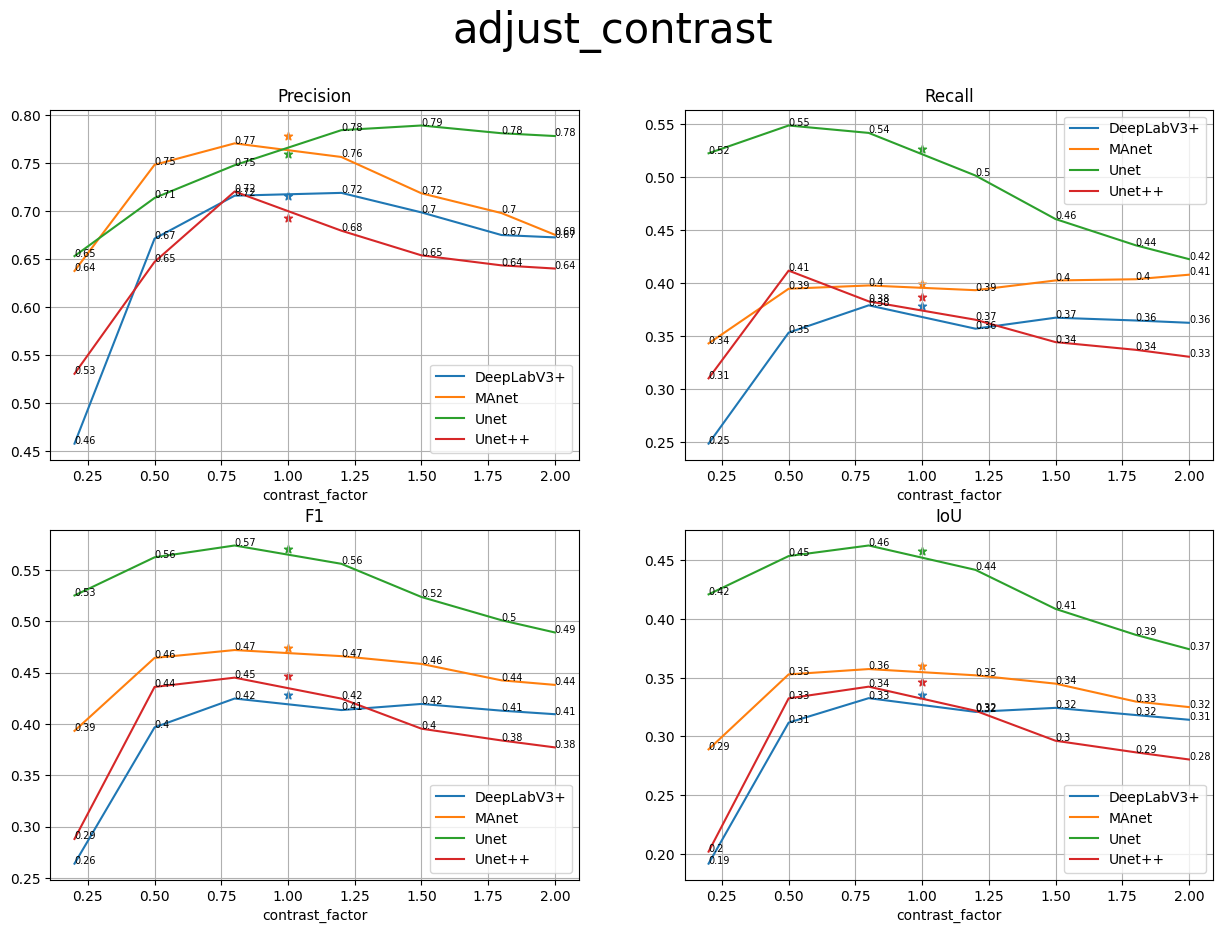

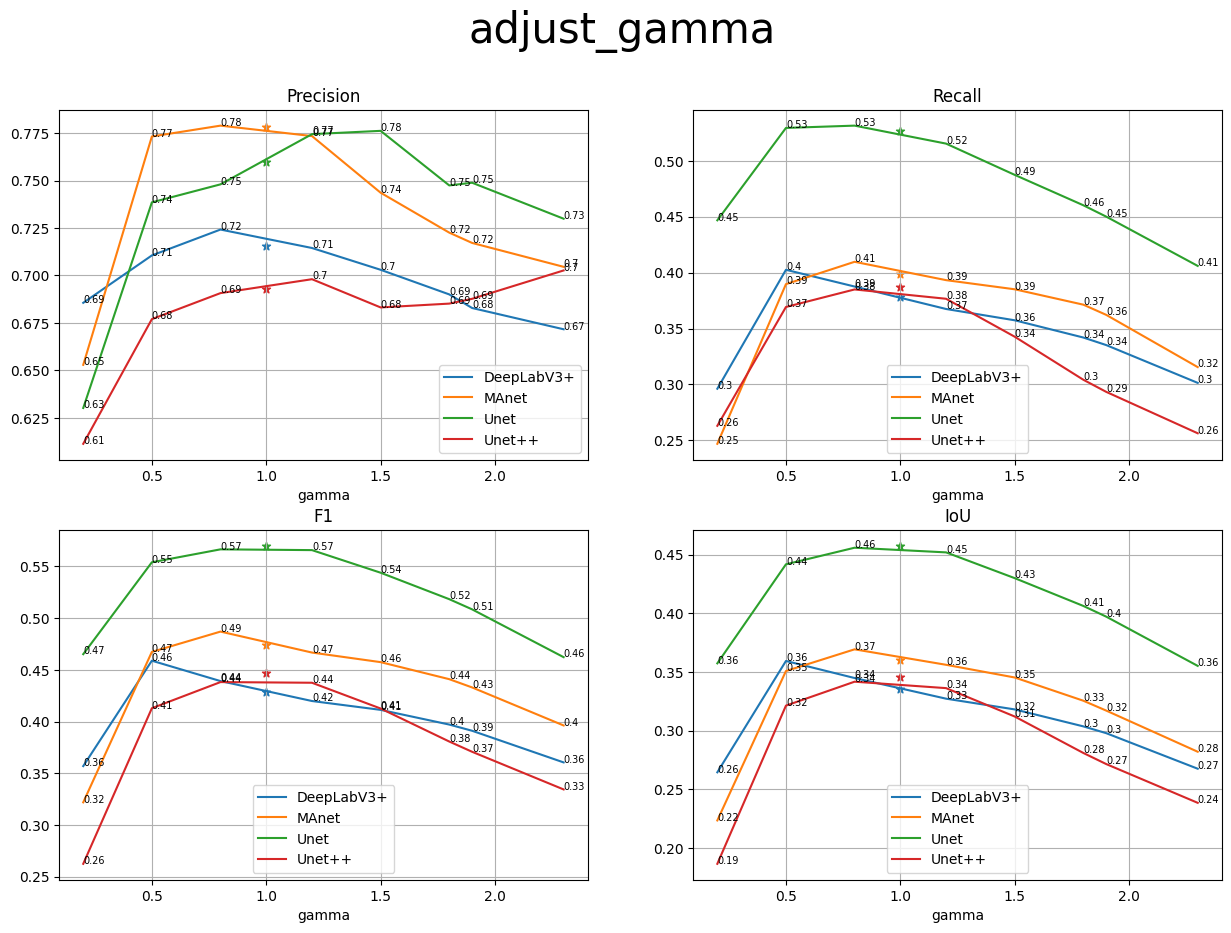

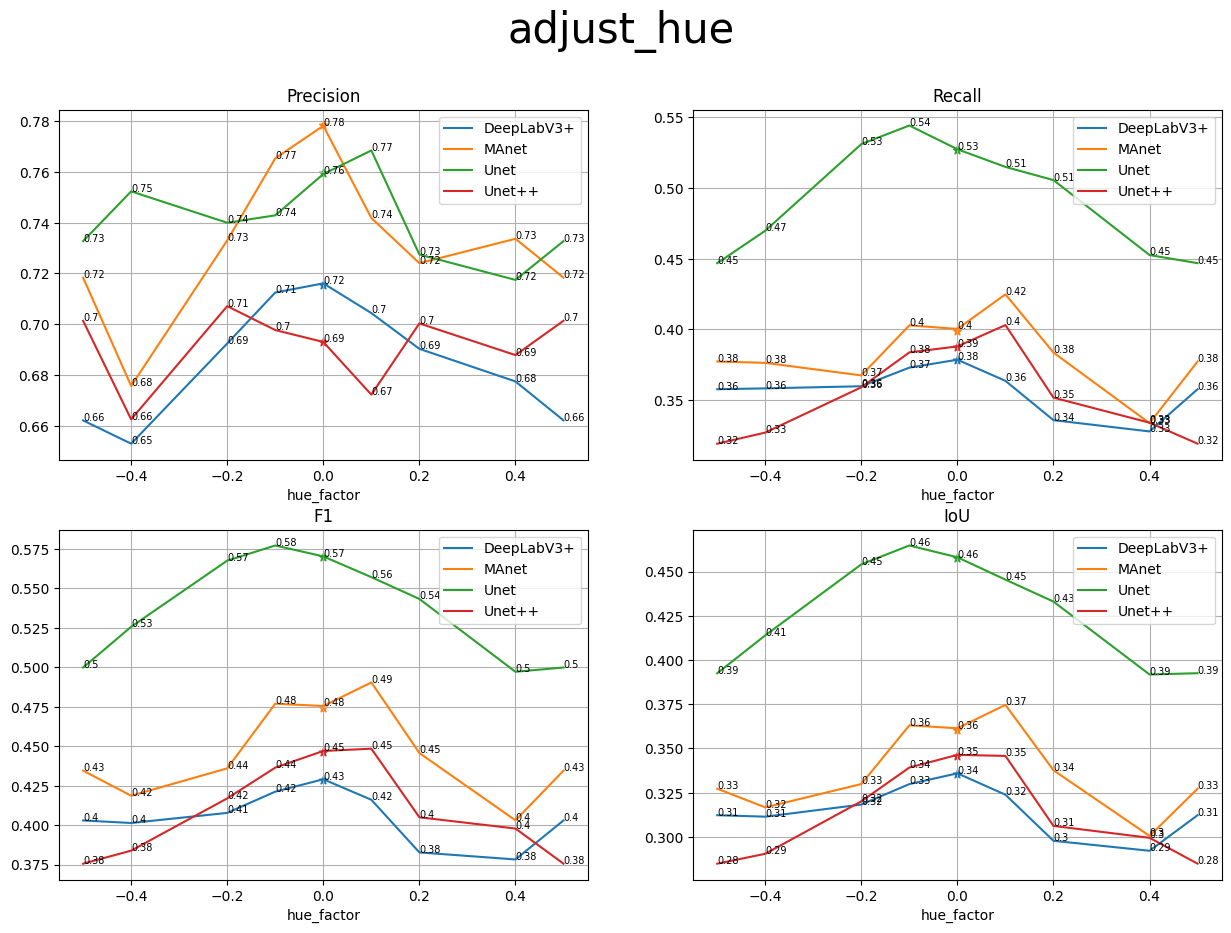

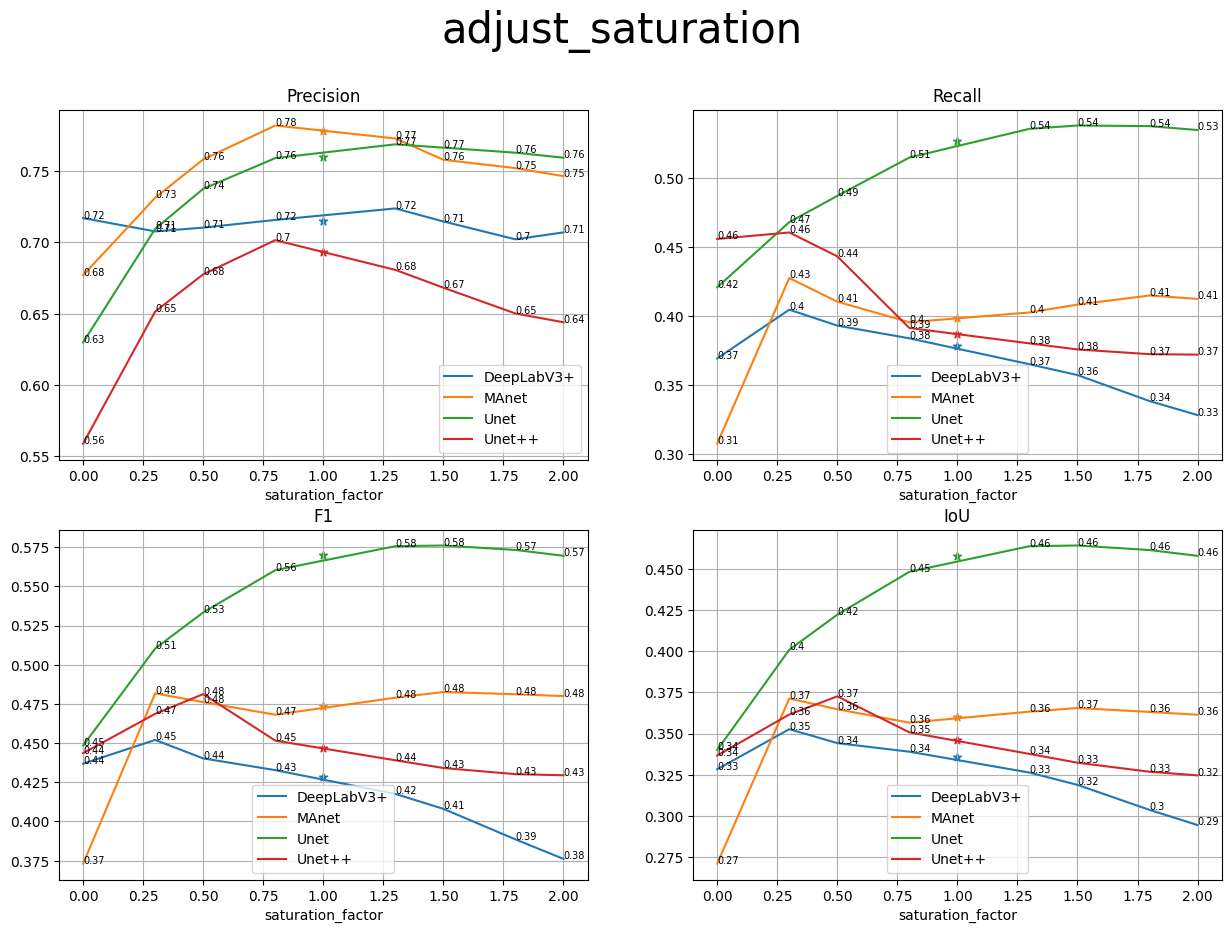

In [85]:
transf_names = ['adjust_contrast', 'adjust_gamma', 'adjust_hue', 'adjust_saturation']
pars = [{'contrast_factor':[0.2, 0.5, 0.8, 1.2, 1.5, 1.8, 2]}, {'gamma':[0.2, 0.5, 0.8, 1.2, 1.5, 1.8, 1.9, 2.3]}, {'hue_factor':[-0.5, -0.4, -0.2, -0.1, 0, 0.1, 0.2, 0.4, 0.5]}, {'saturation_factor':[0, 0.3, 0.5, 0.8, 1.3, 1.5, 1.8, 2]}]
model_names = ['DeepLabV3+_efficientnet-b4' , 'MAnet_efficientnet-b4', 'Unet_mit-b2', 'Unet++_efficientnet-b5']
x0s = [1,1,0,1]
for transf_name, par, x0 in zip(transf_names, pars, x0s):
    par_name, par_val_list = next(iter(par.items()))

    p_all_models, r_all_models, iou_all_models, f1_all_models = [],[],[],[]

    for model_name in model_names:
        p_w_pars, r_w_pars, iou_w_pars, f1_w_pars = [],[],[],[]
        for par_i in par_val_list:
            r_w_pars.append(np.mean(np.load(f'metrics/{model_name}_{transf_name}_{str(par_i)}_recall.npy')))
            p_w_pars.append(np.mean(np.load(f'metrics/{model_name}_{transf_name}_{par_i}_precision.npy')))
            iou_w_pars.append(np.mean(np.load(f'metrics/{model_name}_{transf_name}_{par_i}_IoU.npy')))
            f1_w_pars.append(np.mean(np.load(f'metrics/{model_name}_{transf_name}_{par_i}_f1.npy')))

        p_all_models.append(p_w_pars)
        r_all_models.append(r_w_pars)
        iou_all_models.append(iou_w_pars)
        f1_all_models.append(f1_w_pars)

    plot_means_metrics(par_val_list, p_all_models, r_all_models, f1_all_models, iou_all_models, model_names, transf_name, par_name, x0)

# Create df with metrics


In [91]:
transf_names = ['adjust_contrast', 'adjust_gamma', 'adjust_hue', 'adjust_saturation']
pars = [{'contrast_factor':[0.2, 0.5, 0.8, 1.2, 1.5, 1.8, 2]}, {'gamma':[0.2, 0.5, 0.8, 1.2, 1.5, 1.8, 1.9, 2.3]}, {'hue_factor':[-0.5, -0.4, -0.2, -0.1, 0, 0.1, 0.2, 0.4, 0.5]}, {'saturation_factor':[0, 0.3, 0.5, 0.8, 1.3, 1.5, 1.8, 2]}]
model_names = ['DeepLabV3+_efficientnet-b4' , 'MAnet_efficientnet-b4', 'Unet_mit-b2', 'Unet++_efficientnet-b5']
#transf_names = ['adjust_contrast', 'adjust_gamma', 'adjust_hue', 'adjust_saturation', 'Grayscale','webp']
#pars = [{'contrast_factor':[1.5]}, {'gamma':[1.2]}, {'hue_factor':[0.1]}, {'saturation_factor':[1.5]}, {'out_channels':[3]}, {'webp': [1]}]
    
#model_name = model_names[0]

for model_name in model_names:
    for transf_name, par in zip(transf_names, pars):
        par_name, par_val_list = next(iter(par.items()))
        p,r,f1,iou = [],[],[],[]
        p.append(np.mean(np.load(f'metrics/{model_name}_origin_precision.npy')))
        r.append(np.mean(np.load(f'metrics/{model_name}_origin_recall.npy')))
        f1.append(np.mean(np.load(f'metrics/{model_name}_origin_f1.npy')))
        iou.append(np.mean(np.load(f'metrics/{model_name}_origin_IoU.npy')))

        for par_i in par_val_list: 
            p.append(np.mean(np.load(f'metrics/{model_name}_{transf_name}_{par_i}_precision.npy')))
            r.append(np.mean(np.load(f'metrics/{model_name}_{transf_name}_{str(par_i)}_recall.npy')))
            f1.append(np.mean(np.load(f'metrics/{model_name}_{transf_name}_{par_i}_f1.npy')))
            iou.append(np.mean(np.load(f'metrics/{model_name}_{transf_name}_{par_i}_IoU.npy')))

        df = pd.DataFrame(data = {'P': p, 'R': r, 'F1': f1, 'IoU': iou} , index = ['origin'] + [str(round(x, 1)) for x in par_val_list])

        # Beautiful table with gradation
        dfi.export((df
        .style
        .background_gradient()
        .set_caption(model_name.split('_')[0] + ', ' + transf_name)
        ),'plots/metrics_tables/' + model_name.split('_')[0] + ' ' + transf_name +".png")
        
        # display(df.style.set_caption(model_name.split('_')[0] + ' ' + transf_name))

        #  Table to latex with percent
        tmp_df = df.round(3).astype('str') +' ('+(((df-df.iloc[0])/df.iloc[0]*100).applymap(lambda x: f'+{round(x)}' if x > 0 else str(round(x))))+'%)'
        tmp_df.iloc[0] = df.iloc[0].round(3).astype('str')
        tmp_df.style.background_gradient()
        
        dfi.export((tmp_df
        .style
        .set_caption(model_name.split('_')[0]+ ', ' + transf_name)
        ),'plots/metrics_tables_latex/' + model_name.split('_')[0] + ' ' + transf_name + ".png")

        print(model_name.split('_')[0] + ' ' + transf_name)
        print()
        # display(tmp_df.style.set_caption(model_name.split('_')[0] + ' ' + transf_name))
        print(tmp_df.to_latex())


DeepLabV3+ adjust_contrast

\begin{tabular}{lllll}
\toprule
 & P & R & F1 & IoU \\
\midrule
origin & 0.715 & 0.378 & 0.429 & 0.335 \\
0.2 & 0.457 (-36%) & 0.248 (-34%) & 0.264 (-38%) & 0.192 (-43%) \\
0.5 & 0.671 (-6%) & 0.353 (-7%) & 0.397 (-7%) & 0.312 (-7%) \\
0.8 & 0.716 (+0%) & 0.379 (+0%) & 0.425 (-1%) & 0.333 (-1%) \\
1.2 & 0.719 (+1%) & 0.357 (-6%) & 0.413 (-4%) & 0.321 (-4%) \\
1.5 & 0.699 (-2%) & 0.367 (-3%) & 0.419 (-2%) & 0.324 (-3%) \\
1.8 & 0.675 (-6%) & 0.365 (-4%) & 0.413 (-4%) & 0.318 (-5%) \\
2 & 0.673 (-6%) & 0.363 (-4%) & 0.409 (-4%) & 0.314 (-6%) \\
\bottomrule
\end{tabular}

DeepLabV3+ adjust_gamma

\begin{tabular}{lllll}
\toprule
 & P & R & F1 & IoU \\
\midrule
origin & 0.715 & 0.378 & 0.429 & 0.335 \\
0.2 & 0.686 (-4%) & 0.296 (-22%) & 0.357 (-17%) & 0.264 (-21%) \\
0.5 & 0.711 (-1%) & 0.403 (+6%) & 0.459 (+7%) & 0.359 (+7%) \\
0.8 & 0.724 (+1%) & 0.388 (+2%) & 0.439 (+2%) & 0.345 (+3%) \\
1.2 & 0.714 (0%) & 0.367 (-3%) & 0.42 (-2%) & 0.327 (-2%) \\
1.5 & 0.703 